# Análise Preditiva de Acesso a Recursos (Amazon) - Equipe 2

## CRISP-DM: Data Preparation & Modelling

### Objetivo
Desenvolver e avaliar modelos de machine learning para predição de acesso a recursos da Amazon, incluindo preparação e transformação dos dados, tratamento de desbalanceamento de classes, otimização de hiperparâmetros e comparação de diferentes algoritmos de classificação para determinar se um funcionário deve ter acesso a determinados recursos.

### Informações do Dataset
- **Fonte**: Amazon Employee Access Challenge
- **Problema**: Classificação binária (0 = Acesso Negado, 1 = Acesso Permitido)
- **Dados de Treinamento**: 32.769 registros

## 0. Configurações Iniciais

### 0.1 Importação de Bibliotecas e Configurações

In [ ]:
# # Instalando Dependências
# # Descomente a célula somente se estiver rodando pela primeira vez 
# %pip install -r requirements.txt

In [1]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, loguniform
from random import seed, randrange
from math import sqrt
import time
import joblib

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import NeighbourhoodCleaningRule
from category_encoders import TargetEncoder


# Modelos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklvq import GMLVQ


import warnings
warnings.filterwarnings('ignore')

# Configurações para visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Garante que a pasta 'modelos' existe
import os
os.makedirs('modelos', exist_ok=True)

### 0.2 Definição de LVQ

In [2]:
class LVQ(GMLVQ):
    def predict(self, X):
        decision_values = self.decision_function(X)
        
        if self.classes_.size == 2:
            return self.classes_[(decision_values > 0).astype(np.int64)]  # Changed from np.int to np.int64
        
        return self.classes_[decision_values.argmax(axis=1)]

## 1. Carregamento dos Dados

Nesta seção, realizamos o carregamento dos dados.

In [11]:
# Carregamento dos dados de treinamento
train_df = pd.read_csv('data/train.csv')

# Separar features e target
X = train_df.drop(columns=['ACTION'])
y = train_df['ACTION']

# (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

## 2. Pré-processamento
Como a fase de Análise de Dados já foi feita anteriormente no arquivo `projeto_analise.ipynb`, vamos para o pré-processamento.

In [12]:
# Lista de colunas que são categorias, mas estão com tipo numérico
categorical_int_cols = [
    'MGR_ID',
    'ROLE_ROLLUP_2',
    'ROLE_DEPTNAME',
    'ROLE_TITLE',
    'ROLE_FAMILY_DESC',
    'ROLE_CODE',
    'RESOURCE'
]
for col in categorical_int_cols:
    X_train[col] = X_train[col].astype(str) # Ou .astype('object')
    X_test[col] = X_test[col].astype(str) # o mesmo no teste!
    
print("Novos tipos de dados em X_train:")
print(X_train[categorical_int_cols].info())

Novos tipos de dados em X_train:
<class 'pandas.core.frame.DataFrame'>
Index: 26215 entries, 10137 to 31226
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   MGR_ID            26215 non-null  object
 1   ROLE_ROLLUP_2     26215 non-null  object
 2   ROLE_DEPTNAME     26215 non-null  object
 3   ROLE_TITLE        26215 non-null  object
 4   ROLE_FAMILY_DESC  26215 non-null  object
 5   ROLE_CODE         26215 non-null  object
 6   RESOURCE          26215 non-null  object
dtypes: object(7)
memory usage: 1.6+ MB
None


### 2.1 Divisão das colunas em alta e baixa cardinalidade e remoção de colunas.

In [13]:
# Remover as colunas indesejadas
cols_to_remove = ['ROLE_ROLLUP_1', 'ROLE_FAMILY']
X_train_clean = X_train.drop(columns=cols_to_remove, errors='ignore')
X_test_clean = X_test.drop(columns=cols_to_remove, errors='ignore')

In [14]:
low_card_features = [col for col in X_train_clean.columns if X_train_clean[col].nunique() < 450]
high_card_features = [col for col in X_train_clean.columns if X_train_clean[col].nunique() >= 450]

low_card_features_2 = [col for col in X_train.columns if X_train[col].nunique() < 450]
high_card_features_2 = [col for col in X_train.columns if X_train[col].nunique() >= 450]

print("Colunas de baixa e alta cardinalidade em X_train_clean:")
print("Baixa cardinalidade:", low_card_features)
print("Alta cardinalidade:", high_card_features)

print("\nColunas de baixa e alta cardinalidade em X_train:")
print("Baixa cardinalidade:", low_card_features_2)
print("Alta cardinalidade:", high_card_features_2)

Colunas de baixa e alta cardinalidade em X_train_clean:
Baixa cardinalidade: ['ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_CODE']
Alta cardinalidade: ['RESOURCE', 'MGR_ID', 'ROLE_FAMILY_DESC']

Colunas de baixa e alta cardinalidade em X_train:
Baixa cardinalidade: ['ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY', 'ROLE_CODE']
Alta cardinalidade: ['RESOURCE', 'MGR_ID', 'ROLE_FAMILY_DESC']


### 2.2 Comparação de Estratégias de Pré-processamento

Neste experimento, avaliamos o impacto da remoção de colunas no pré-processamento dos dados. Foram testados dois cenários:

- **Com remoção de colunas:**  
    As colunas `ROLE_ROLLUP_1` e `ROLE_FAMILY` foram removidas antes do pré-processamento.

- **Sem remoção de colunas:**  
    Todas as colunas originais foram mantidas no pré-processamento.

O pré-processador utilizado para ambos os cenários foi:

- **Pré-processador para os modelos:**  
    `OneHotEncoder` para variáveis de baixa cardinalidade (`low_cardinality_features`) e `TargetEncoder` para variáveis de alta cardinalidade (`high_cardinality_features`).

A comparação dos resultados permite avaliar se a exclusão dessas colunas influencia o desempenho dos modelos de classificação.

In [15]:
# Definições de baixa e alta cardinalidade para ambos os conjuntos
low_card_features = [col for col in X_train_clean.columns if X_train_clean[col].nunique() < 450]
high_card_features = [col for col in X_train_clean.columns if X_train_clean[col].nunique() >= 450]

low_card_features_2 = [col for col in X_train.columns if X_train[col].nunique() < 450]
high_card_features_2 = [col for col in X_train.columns if X_train[col].nunique() >= 450]

# Pré-processador para X_train_clean
preprocessor_clean = ColumnTransformer(transformers=[
    ('low_card', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary', min_frequency=0.01), low_card_features),
    ('high_card', TargetEncoder(smoothing=1.0, min_samples_leaf=20), high_card_features)
], remainder='passthrough')

# Pré-processador para X_train (todas as colunas)
preprocessor_full = ColumnTransformer(transformers=[
    ('low_card', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary', min_frequency=0.01), low_card_features_2),
    ('high_card', TargetEncoder(smoothing=1.0, min_samples_leaf=20), high_card_features_2)
], remainder='passthrough')

In [16]:
# Importe o ImbPipeline se ainda não o fez
from imblearn.pipeline import Pipeline as ImbPipeline

def create_pipeline(classifier, use_full=False):
    """
    Cria um pipeline com três etapas:
    1. Pré-processador para transformar os dados.
    2. Reamostrador para balancear os dados (APENAS NO TREINO).
    3. Classificador para realizar a predição.
    
    Parâmetros:
    - classifier: o estimador/classificador a ser usado.
    - use_full: se True, usa preprocessor_full; senão, usa preprocessor_clean.
    """
    preproc = preprocessor_full if use_full else preprocessor_clean
    
    # O reamostrador
    ncr_resampler = NeighbourhoodCleaningRule(
        sampling_strategy='majority',
        n_neighbors=5,
        kind_sel='mode',
        n_jobs=-1
    )
    
    return ImbPipeline(steps=[
        ('preprocessor', preproc),
        ('resampler', ncr_resampler), # A etapa de balanceamento está AQUI
        ('classifier', classifier)
    ])

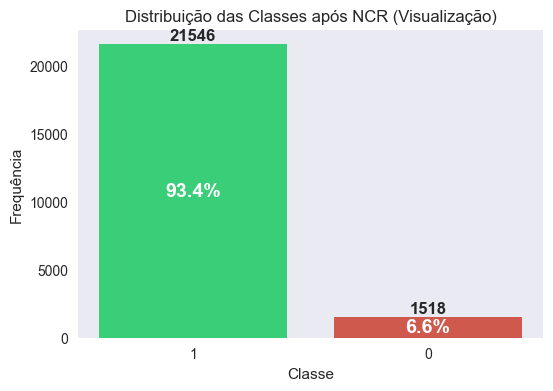

In [18]:
# 1. Crie um pipeline apenas com as etapas de pré-processamento e reamostragem
ncr_resampler_vis = NeighbourhoodCleaningRule(
    sampling_strategy='majority',
    n_neighbors=5,
    kind_sel='mode',
    n_jobs=-1
)

visualization_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor_clean),
    ('resampler', ncr_resampler_vis)
])

# 2. Aplique o pipeline aos dados de treino originais para obter os dados reamostrados
X_vis, y_vis = visualization_pipeline.fit_resample(X_train_clean, y_train)


# 3. Use o seu código de plotagem com a nova variável 'y_vis'
counts = y_vis.value_counts()
proportions = y_vis.value_counts(normalize=True)

# Visualização gráfica
plt.figure(figsize=(6,4))
bars = plt.bar(counts.index.astype(str), counts.values, color=["#3ACE78", "#CE594C"])
plt.title("Distribuição das Classes após NCR (Visualização)")
plt.xlabel("Classe")
plt.ylabel("Frequência")
for bar, count, prop in zip(bars, counts.values, proportions.values):
    plt.text(
        bar.get_x() + bar.get_width()/2., 
        bar.get_height()/2,
        f'{prop:.1%}', 
        ha='center', va='center', fontweight='bold', color='white', fontsize=14
    )
    plt.text(
        bar.get_x() + bar.get_width()/2., 
        bar.get_height() + 50,
        f'{count}', 
        ha='center', va='bottom', fontweight='bold'
    )
plt.grid(False)
plt.show()

## 3. Seleção de Modelos Fase 

### 3.1 Fase 1

Modelos avaliados nesta fase:

- **K-NN** (K-Nearest Neighbors)
- **Árvore de Decisão** (Decision Tree)
- **Random Forest**
- **SVM** (Support Vector Machine)
- **LVQ** (Learning Vector Quantization)


In [8]:
models = {
    "K-NN": KNeighborsClassifier(),
    "Árvore de Decisão": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM (Kernel RBF)": SVC(random_state=42, max_iter=1000, probability=True),
    "GMLVQ" : LVQ(random_state=42)
}

In [7]:
# Dicionário de métricas que queremos calcular
scoring = {
    'precision_0': make_scorer(precision_score, pos_label=0, zero_division=0),
    'precision_1': make_scorer(precision_score, pos_label=1, zero_division=0),
    'recall_0': make_scorer(recall_score, pos_label=0, zero_division=0),
    'recall_1': make_scorer(recall_score, pos_label=1, zero_division=0),
    'f1_0': make_scorer(f1_score, pos_label=0, zero_division=0),
    'f1_weighted': make_scorer(f1_score, average='weighted', zero_division=0)
}

# Estratégia de validação cruzada estratificada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Dicionário para armazenar os resultados finais
results_clean = {}
results_full = {}
results_NCR = {}

In [63]:
# Loop para avaliar cada modelo do seu dicionário 'models'
for name, model in models.items():
    print(f"Avaliando : {name}...")
    
    # Criação do Pipeline Simples
    # Etapa 1: 'preprocessor_full' que você já definiu (com OneHotEncoder e TargetEncoder).
    # Etapa 2: O classificador da vez (K-NN, Árvore de Decisão, etc.).
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor_full),
        ('classifier', model)
    ])
    
    # Executa a validação cruzada no pipeline
    # Os dados de treino são os originais e completos: X_train e y_train
    scores = cross_validate(
        pipeline, 
        X_train, 
        y_train,
        cv=cv_strategy, 
        scoring=scoring, 
        n_jobs=-1
    )
    
    # Armazena a média dos resultados
    results_full[name] = {
        'precision_0_media': scores['test_precision_0'].mean(),
        'precision_1_media': scores['test_precision_1'].mean(),
        'recall_0_media': scores['test_recall_0'].mean(),
        'recall_1_media': scores['test_recall_1'].mean(),
        'f1_0_media': scores['test_f1_0'].mean(),
        'f1_weighted_media': scores['test_f1_weighted'].mean()
    }

Avaliando (todas as colunas): K-NN...
Avaliando (todas as colunas): Árvore de Decisão...
Avaliando (todas as colunas): Random Forest...
Avaliando (todas as colunas): SVM (Kernel RBF)...
Avaliando (todas as colunas): GMLVQ...


In [64]:
# Loop para avaliar cada modelo do seu dicionário 'models'
for name, model in models.items():
    print(f"Avaliando X_train_clean: {name}...")
    
    # Criação do Pipeline Simples
    # Etapa 1: 'preprocessor_clean' que você já definiu.
    # Etapa 2: O classificador da vez.
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor_clean),
        ('classifier', model)
    ])
    
    # Executa a validação cruzada no pipeline
    # Os dados de treino são X_train_clean e y_train
    scores = cross_validate(
        pipeline, 
        X_train_clean, 
        y_train,
        cv=cv_strategy, 
        scoring=scoring, 
        n_jobs=-1
    )
    
    # Armazena a média dos resultados
    results_clean[name] = {
        'precision_0_media': scores['test_precision_0'].mean(),
        'precision_1_media': scores['test_precision_1'].mean(),
        'recall_0_media': scores['test_recall_0'].mean(),
        'recall_1_media': scores['test_recall_1'].mean(),
        'f1_0_media': scores['test_f1_0'].mean(),
        'f1_weighted_media': scores['test_f1_weighted'].mean()
    }


Avaliando X_train_clean: K-NN...
Avaliando X_train_clean: Árvore de Decisão...
Avaliando X_train_clean: Random Forest...
Avaliando X_train_clean: SVM (Kernel RBF)...
Avaliando X_train_clean: GMLVQ...


In [69]:
# Loop de avaliação
for name, model in models.items():
    print(f"Avaliando com Resampling (NCR): {name}...")
    
    # Criamos o pipeline com colunas limpas (use_full=False) 
    # e COM reamostragem (use_resampling=True)
    pipeline = create_pipeline(model, use_full=False)
    
    scores = cross_validate(
        pipeline,
        X_train_clean,  # Usamos os dados originais, o pipeline cuida do resto
        y_train,
        cv=cv_strategy,
        scoring=scoring,
        n_jobs=-1
    )
    
    results_NCR[name] = {
        'precision_0_media': scores['test_precision_0'].mean(),
        'precision_1_media': scores['test_precision_1'].mean(),
        'recall_0_media': scores['test_recall_0'].mean(),
        'recall_1_media': scores['test_recall_1'].mean(),
        'f1_0_media': scores['test_f1_0'].mean(),
        'f1_weighted_media': scores['test_f1_weighted'].mean()
    }

Avaliando com Resampling (NCR): K-NN...
Avaliando com Resampling (NCR): Árvore de Decisão...
Avaliando com Resampling (NCR): Random Forest...
Avaliando com Resampling (NCR): SVM (Kernel RBF)...
Avaliando com Resampling (NCR): GMLVQ...


In [65]:
# --- Visualização dos Resultados ---
results_full_df = pd.DataFrame(results_full).T
results_full_df = results_full_df.sort_values(by='f1_0_media', ascending=False)
print("\n" + "=" * 60)
print("       RESULTADO BASELINE (DADOS COMPLETOS E SEM RESAMPLING)")
print("=" * 60)
print(results_full_df)


       RESULTADO BASELINE (DADOS COMPLETOS E SEM RESAMPLING)
                   precision_0_media  precision_1_media  recall_0_media  \
Random Forest               0.576664           0.959505        0.323488   
Árvore de Decisão           0.351197           0.961511        0.376860   
GMLVQ                       0.060664           0.943712        0.387927   
SVM (Kernel RBF)            0.081171           0.941945        0.082455   
K-NN                        0.201639           0.943302        0.028974   

                   recall_1_media  f1_0_media  f1_weighted_media  
Random Forest            0.985140    0.412679           0.939751  
Árvore de Decisão        0.956796    0.362669           0.924598  
GMLVQ                    0.630523    0.104773           0.717522  
SVM (Kernel RBF)         0.915542    0.054342           0.876476  
K-NN                     0.992955    0.050414           0.914388  


In [67]:
# --- Visualização dos Resultados ---
results_clean_df = pd.DataFrame(results_clean).T
results_clean_df = results_clean_df.sort_values(by='f1_0_media', ascending=False)

print("\n" + "=" * 60)
print("     RESULTADO BASELINE (DADOS COM COLUNAS REMOVIDAS E SEM RESAMPLING)")
print("=" * 60)
print(results_clean_df)


     RESULTADO BASELINE (DADOS COM COLUNAS REMOVIDAS E SEM RESAMPLING)
                   precision_0_media  precision_1_media  recall_0_media  \
Random Forest               0.582186           0.957985        0.295813   
Árvore de Decisão           0.358011           0.961601        0.377488   
GMLVQ                       0.058546           0.942704        0.408409   
SVM (Kernel RBF)            0.080119           0.943338        0.125932   
K-NN                        0.201639           0.943302        0.028974   

                   recall_1_media  f1_0_media  f1_weighted_media  
Random Forest            0.986800    0.390896           0.938515  
Árvore de Decisão        0.958133    0.366853           0.925518  
GMLVQ                    0.597874    0.101895           0.689927  
SVM (Kernel RBF)         0.893395    0.072928           0.867102  
K-NN                     0.992955    0.050414           0.914388  


In [ ]:
results_NCR_df = pd.DataFrame(results_NCR).T
results_NCR_df = results_NCR_df.sort_values(by='f1_0_media', ascending=False)

print("\n" + "=" * 60)
print("      RESULTADO BASELINE (DADOS COM COLUNAS REMOVIDAS E COM RESAMPLING)")
print("=" * 60)
print(results_NCR_df)


             RESULTADO FINAL DA AVALIAÇÃO COM RESAMPLING
                   precision_0_media  precision_1_media  recall_0_media  \
Random Forest               0.506766           0.961557        0.363668   
Árvore de Decisão           0.291091           0.964867        0.447334   
K-NN                        0.153843           0.946270        0.110701   
GMLVQ                       0.059008           0.942787        0.426076   
SVM (Kernel RBF)            0.046167           0.941616        0.073863   

                   recall_1_media  f1_0_media  f1_weighted_media  
Random Forest            0.978175    0.422521           0.938100  
Árvore de Decisão        0.932826    0.352283           0.914037  
K-NN                     0.962627    0.128246           0.906532  
GMLVQ                    0.581454    0.102941           0.677174  
SVM (Kernel RBF)         0.919059    0.044822           0.876757  


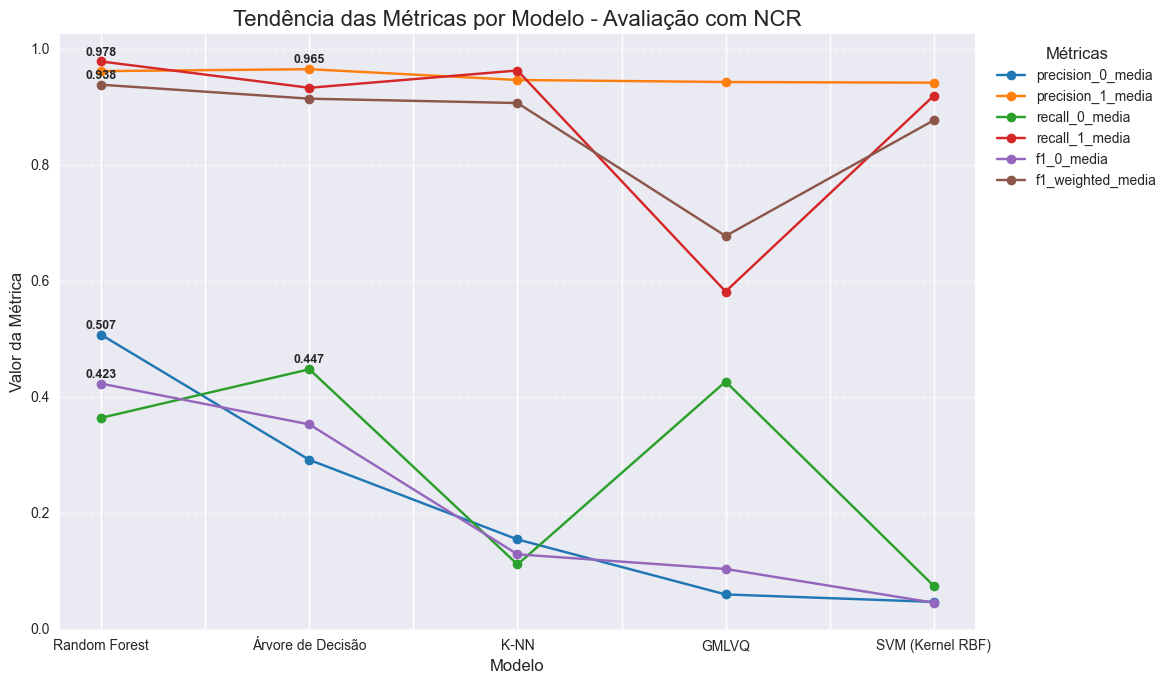

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Dicionário de cores para as MÉTRICAS ---
cores_metricas = {
    'precision_0_media': '#1f77b4',  # Azul
    'precision_1_media': '#ff7f0e',  # Laranja
    'recall_0_media':    '#2ca02c',  # Verde
    'recall_1_media':    '#d62728',  # Vermelho
    'f1_0_media':        '#9467bd',  # Roxo
    'f1_weighted_media': '#8c564b'   # Marrom
}


# --- Criação do Gráfico ---
fig, ax = plt.subplots(figsize=(14, 7))

# Plotamos o DataFrame, passando o novo dicionário de cores
results_NCR_df.plot(
    kind='line',
    marker='o',
    ax=ax,
    color=cores_metricas  
)

# --- Loop para anotar o ponto de maior valor de cada métrica ---
for metrica in results_NCR_df.columns:
    serie_metrica = results_NCR_df[metrica]
    max_valor = serie_metrica.max()
    max_modelo = serie_metrica.idxmax()
    pos_x = list(results_NCR_df.index).index(max_modelo)
    
    ax.text(
        pos_x,
        max_valor + 0.005,
        f'{max_valor:.3f}',
        ha='center',
        va='bottom',
        fontweight='bold',
        fontsize=9
    )

# --- Customização final do Gráfico ---
plt.title('Tendência das Métricas por Modelo - Avaliação com NCR', fontsize=16)
plt.ylabel('Valor da Métrica', fontsize=12)
plt.xlabel('Modelo', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Métricas', bbox_to_anchor=(1.01, 1), loc='upper left') 
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

### 3.2 Fase 2

- **Rede Neural MLP (Multilayer Perceptron)**
- **Comitê de Redes Neurais Artificiais**
- **Comitê Heterogêneo (Stacking)**
- **XGBoost**
- **LightGBM**


In [20]:

models_fase2 = {
    "MLP": MLPClassifier(random_state=42, max_iter=300),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42, verbose=-1)
    }

# --- Comitê de Redes Neurais (Voting) ---
mlp1 = MLPClassifier(random_state=1, max_iter=300)
mlp2 = MLPClassifier(random_state=2, max_iter=300)
mlp3 = MLPClassifier(random_state=3, max_iter=300)
voting_mlp = VotingClassifier(
    estimators=[('mlp1', mlp1), ('mlp2', mlp2), ('mlp3', mlp3)],
    voting='soft',
    n_jobs=-1
)

# --- Comitê Heterogêneo (Stacking) ---
estimators_stacking = [
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('mlp', MLPClassifier(random_state=42, max_iter=300))
]
stacking_committee = StackingClassifier(
    estimators=estimators_stacking,
    final_estimator=RandomForestClassifier(random_state=43),
    cv=cv_strategy,
    n_jobs=-1
)

# Dicionário com os modelos de comitê para avaliação
committee_models = {
    "Comitê MLPs (Voting)": voting_mlp,
    "Comitê Heterogêneo (Stacking)": stacking_committee
}


results_fase2 = {}

In [93]:
# Loop para avaliar cada modelo da Fase 2
for name, model in models_fase2.items():
    print(f"Avaliando modelo baseline: {name}...")


    pipeline = create_pipeline(model, use_full=False)

    # Executa a validação cruzada no pipeline com os dados limpos
    scores = cross_validate(
        pipeline,
        X_train_clean,
        y_train,
        cv=cv_strategy,
        scoring=scoring,
        n_jobs=-1
    )

    # Armazena a média dos resultados
    results_fase2[name] = {
        'precision_0_media': scores['test_precision_0'].mean(),
        'precision_1_media': scores['test_precision_1'].mean(),
        'recall_0_media': scores['test_recall_0'].mean(),
        'recall_1_media': scores['test_recall_1'].mean(),
        'f1_0_media': scores['test_f1_0'].mean(),
        'f1_weighted_media': scores['test_f1_weighted'].mean()
    }

Avaliando modelo baseline: MLP...
Avaliando modelo baseline: XGBoost...
Avaliando modelo baseline: LightGBM...


In [94]:
# Loop para avaliar cada modelo de comitês
for name, model in committee_models.items():
    print(f"Avaliando modelo baseline: {name}...")

    pipeline = create_pipeline(model, use_full=False)

    # Executa a validação cruzada no pipeline com os dados limpos
    scores = cross_validate(
        pipeline,
        X_train_clean,
        y_train,
        cv=cv_strategy,
        scoring=scoring,
        n_jobs=-1
    )

    # Armazena a média dos resultados
    results_fase2[name] = {
        'precision_0_media': scores['test_precision_0'].mean(),
        'precision_1_media': scores['test_precision_1'].mean(),
        'recall_0_media': scores['test_recall_0'].mean(),
        'recall_1_media': scores['test_recall_1'].mean(),
        'f1_0_media': scores['test_f1_0'].mean(),
        'f1_weighted_media': scores['test_f1_weighted'].mean()
    }

Avaliando modelo baseline: Comitê MLPs (Voting)...
Avaliando modelo baseline: Comitê Heterogêneo (Stacking)...


In [95]:
# --- Visualização dos Resultados em DataFrame ---
results_fase2_df = pd.DataFrame(results_fase2).T
results_fase2_df = results_fase2_df.sort_values(by='f1_0_media', ascending=False)

print("\n" + "=" * 80)
print("             RESULTADO BASELINE DA FASE 2 COM RESAMPLING")
print("=" * 80)
print(results_fase2_df)


             RESULTADO BASELINE DA FASE 2 COM RESAMPLING
                               precision_0_media  precision_1_media  \
XGBoost                                 0.441154           0.966299   
Comitê Heterogêneo (Stacking)           0.412748           0.967174   
LightGBM                                0.382511           0.954011   
Comitê MLPs (Voting)                    0.411197           0.951146   
MLP                                     0.401984           0.950580   

                               recall_0_media  recall_1_media  f1_0_media  \
XGBoost                              0.452536        0.964570    0.445925   
Comitê Heterogêneo (Stacking)        0.470347        0.958699    0.438540   
LightGBM                             0.233871        0.976718    0.289137   
Comitê MLPs (Voting)                 0.177239        0.984451    0.246252   
MLP                                  0.166696        0.985018    0.234184   

                               f1_weighted_media  
X

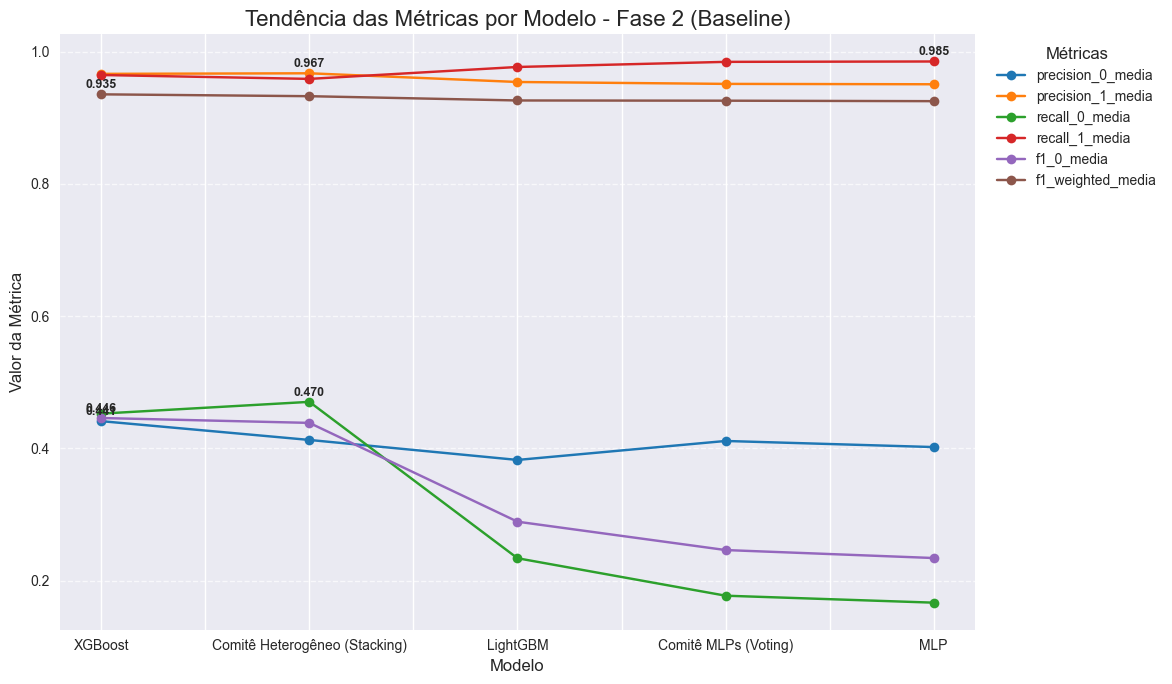

In [98]:
# --- Dicionário de cores para as MÉTRICAS ---
cores_metricas = {
    'precision_0_media': '#1f77b4',  # Azul
    'precision_1_media': '#ff7f0e',  # Laranja
    'recall_0_media':    '#2ca02c',  # Verde
    'recall_1_media':    '#d62728',  # Vermelho
    'f1_0_media':        '#9467bd',  # Roxo
    'f1_weighted_media': '#8c564b'   # Marrom
}

# --- Criação do Gráfico ---
fig, ax = plt.subplots(figsize=(14, 7))

results_fase2_df.plot(
    kind='line',
    marker='o',
    ax=ax,
    color=cores_metricas  
)

# --- Loop para anotar o ponto de maior valor de cada métrica ---
for metrica in results_fase2_df.columns:
    serie_metrica = results_fase2_df[metrica]
    
    max_valor = serie_metrica.max()
    max_modelo = serie_metrica.idxmax()
    
    pos_x = list(results_fase2_df.index).index(max_modelo)
    
    ax.text(
        pos_x,
        max_valor + 0.005,
        f'{max_valor:.3f}',
        ha='center',
        va='bottom',
        fontweight='bold',
        fontsize=9
    )

# --- Customização final do Gráfico ---
plt.title('Tendência das Métricas por Modelo - Fase 2 (Baseline)', fontsize=16)
plt.ylabel('Valor da Métrica', fontsize=12)
plt.xlabel('Modelo', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Métricas', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

## 4. Busca de Hiperparâmetros

### 4.1 Fase 1

Modelos avaliados nesta fase:

- **K-NN** (K-Nearest Neighbors)
- **Árvore de Decisão** (Decision Tree)
- **SVM** (Support Vector Machine)
- **Random Forest**
- **LVQ** (Learning Vector Quantization)


In [46]:
# --- Dicionário com as Distribuições de Hiperparâmetros ---
param_distributions = {
    "K-NN": {
        'classifier__n_neighbors': randint(3, 30),
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan']
    },
    "Árvore de Decisão": {
        'classifier__max_depth': randint(3, 21),
        'classifier__min_samples_split': randint(2, 11),
        'classifier__min_samples_leaf': randint(1, 11),
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__class_weight': ['balanced', None]
    },
    "Random Forest": {
        'classifier__n_estimators': randint(50, 301),
        'classifier__max_depth': randint(3, 21),
        'classifier__min_samples_split': randint(2, 11),
        'classifier__min_samples_leaf': randint(1, 11),
        'classifier__max_features': ['sqrt', 'log2', None],
        'classifier__class_weight': ['balanced', None],
        'classifier__bootstrap': [True, False]
    },
    "SVM (Kernel RBF)": {
        'classifier__C': loguniform(0.1, 100),
        'classifier__gamma': loguniform(0.001, 1),
        'classifier__kernel': ['rbf'],
        'classifier__class_weight': ['balanced', None]
    }
    # "GMLVQ": {
    #     'classifier__prototype_n_per_class': randint(1, 10), # Corrigido de 'prototypes_per_class'
    #     'classifier__relevance_regularization': loguniform(1e-4, 1.0),
    #     'classifier__activation_type': ['sigmoid', 'soft+'],
    #     'classifier__solver_type': ['lbfgs', 'sgd']
    # }
}

In [ ]:
# Vamos criar um dicionário temporário apenas com o modelo GMLVQ para o teste
# model_to_test = {
# "GMLVQ": models["GMLVQ"]
# }

# # Loop de otimização para o GMLVQ
# for name, model in model_to_test.items():
# print(f"--- Testando a otimização do modelo: {name} ---")

# # Cria o pipeline com pré-processamento e reamostragem
# pipeline = create_pipeline(model, use_full=False)

# # Configura a busca aleatória
# search = RandomizedSearchCV(
#     pipeline,
#     param_distributions=param_distributions[name],
#     n_iter=3,
#     cv=cv_strategy,
#     scoring=scoring['f1_0'],
#     n_jobs=-1,
#     random_state=42,
#     verbose=1
# )

# # Executa a busca nos dados de treino
# search.fit(X_train_clean, y_train)

# # Salva o melhor modelo encontrado
# best_model = search.best_estimator_
# print(f"\nBusca concluída com sucesso!")
# print(f"Melhores hiperparâmetros para {name}:")
# print(search.best_params_)

# # Salva o modelo otimizado
# joblib.dump(best_model, f'modelos/{name}_otimizado.pkl')
# print(f"\nModelo '{name}' otimizado e salvo.")

# # --- Avaliação Final no Conjunto de Teste ---
# print(f"Gerando Matriz de Confusão para '{name}' no conjunto de teste...")
# y_pred = best_model.predict(X_test_clean)
# cm = confusion_matrix(y_test, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
# disp.plot(cmap='Blues')
# plt.title(f'Matriz de Confusão Final - {name} (Otimizado)')
# plt.show()
# print("-" * 80)


In [51]:
# Dicionário para armazenar os resultados detalhados de todas as iterações
all_results_fase1 = {}

# Número de iterações da nossa simulação para cada modelo
n_sim_iterations = 20

# Loop principal para otimizar cada modelo
for name, model in models.items():
    print(f"--> Otimizando o modelo: {name}")
    
    # Listas para armazenar resultados de cada simulação
    iteration_best_scores = []  # O melhor score de cada busca
    iteration_mean_scores = []  # A média do CV do melhor estimador de cada busca
    iteration_std_scores = []   # O desvio padrão do CV do melhor estimador de cada busca
    iteration_params = []       # Os melhores parâmetros de cada busca
    
    best_overall_score = -1 # Para rastrear o melhor score geral e salvar o melhor modelo
    
    # Loop para executar múltiplas simulações da busca
    for iteration in range(n_sim_iterations):
        print(f"    Iniciando iteração {iteration+1}/{n_sim_iterations} para {name}...")

        # Ajusta o n_iter para modelos mais lentos
        if name in ["Random Forest", "SVM (Kernel RBF)", "GMLVQ"]:
            n_iter_search = 3 # Menos combinações para modelos complexos
        else:
            n_iter_search = 10

        # Cria o pipeline com pré-processamento e reamostragem
        pipeline = create_pipeline(model, use_full=False)

        # Configura a busca aleatória de hiperparâmetros
        random_search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=param_distributions[name],
            n_iter=n_iter_search,
            cv=cv_strategy,
            scoring=scoring['f1_0'],  # Métrica correta
            n_jobs=-1,
            random_state=42 + iteration, # Seed diferente para cada simulação
            verbose=2
        )

        # Executa a busca nos dados de treino 
        random_search.fit(X_train_clean, y_train)
        
        # --- Captura dos resultados detalhados ---
        best_index = random_search.best_index_
        mean_cv_score = random_search.cv_results_['mean_test_score'][best_index]
        std_cv_score = random_search.cv_results_['std_test_score'][best_index]
        
        # Armazena os resultados desta simulação
        iteration_best_scores.append(random_search.best_score_)
        iteration_mean_scores.append(mean_cv_score)
        iteration_std_scores.append(std_cv_score)
        iteration_params.append(random_search.best_params_)
        
        print(f"        -> Iteração {iteration+1}: Best F1-Score (classe 0): {random_search.best_score_:.4f}")
        print(f"        -> Parâmetros: {random_search.best_params_}")
        print(f"        -> Média CV: {mean_cv_score:.4f} | Desvio CV: {std_cv_score:.4f}")

        # Salva o melhor modelo encontrado até agora
        if random_search.best_score_ > best_overall_score:
            best_overall_score = random_search.best_score_
            joblib.dump(random_search.best_estimator_, f'modelos/{name}_otimizado.pkl')
            print(f"        -> Novo melhor modelo salvo para '{name}' (F1-Score: {best_overall_score:.4f})")
    
    # Armazena todos os resultados para este modelo
    all_results_fase1[name] = {
        'best_scores': iteration_best_scores,
        'mean_scores': iteration_mean_scores,
        'std_scores': iteration_std_scores,
        'params': iteration_params,
        'overall_best_score': best_overall_score,
        'overall_best_params': iteration_params[np.argmax(iteration_best_scores)]
    }
    
    # Resumo dos resultados para este modelo
    print(f"\n    Otimização de '{name}' concluída.")
    print(f"    Melhor F1-Score (classe 0) encontrado: {best_overall_score:.4f}")
    print(f"    Melhores Parâmetros: {all_results_fase1[name]['overall_best_params']}")
    print("-" * 70)

--> Otimizando o modelo: K-NN
    Iniciando iteração 1/20 para K-NN...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
        -> Iteração 1: Best F1-Score (classe 0): 0.3772
        -> Parâmetros: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 8, 'classifier__weights': 'distance'}
        -> Média CV: 0.3772 | Desvio CV: 0.0249
        -> Novo melhor modelo salvo para 'K-NN' (F1-Score: 0.3772)
    Iniciando iteração 2/20 para K-NN...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
        -> Iteração 2: Best F1-Score (classe 0): 0.3871
        -> Parâmetros: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 5, 'classifier__weights': 'uniform'}
        -> Média CV: 0.3871 | Desvio CV: 0.0205
        -> Novo melhor modelo salvo para 'K-NN' (F1-Score: 0.3871)
    Iniciando iteração 3/20 para K-NN...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
        -> Iteração 3: Best F1-Score (classe 0): 0.3837
        -> Parâmetr

KeyError: 'GMLVQ'

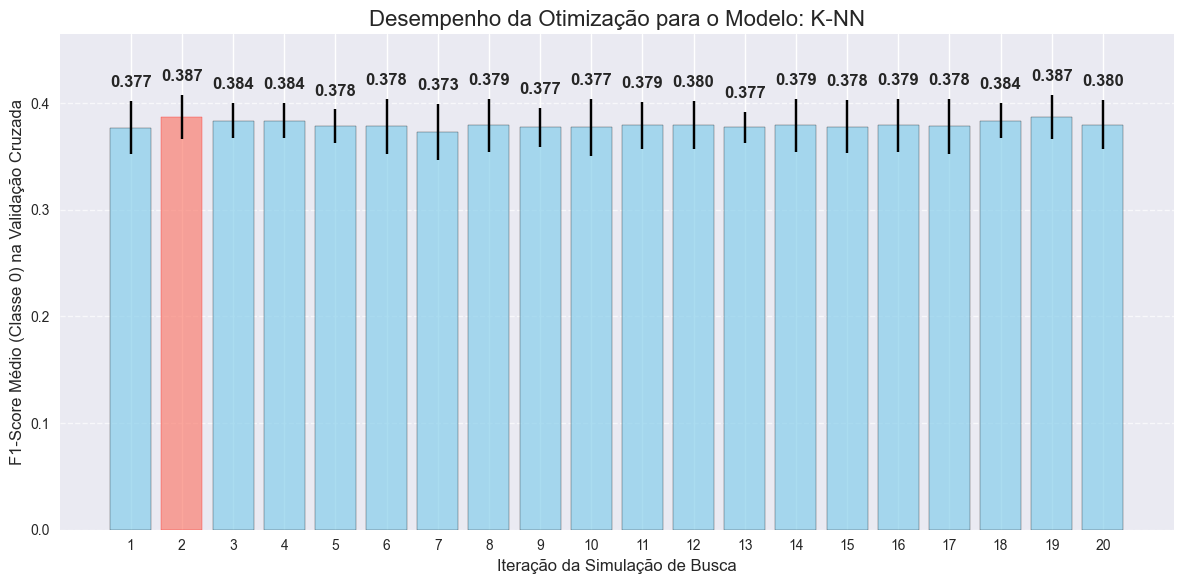

Melhores Parâmetros Gerais para 'K-NN':
{'classifier__metric': 'manhattan', 'classifier__n_neighbors': 5, 'classifier__weights': 'uniform'}
----------------------------------------------------------------------


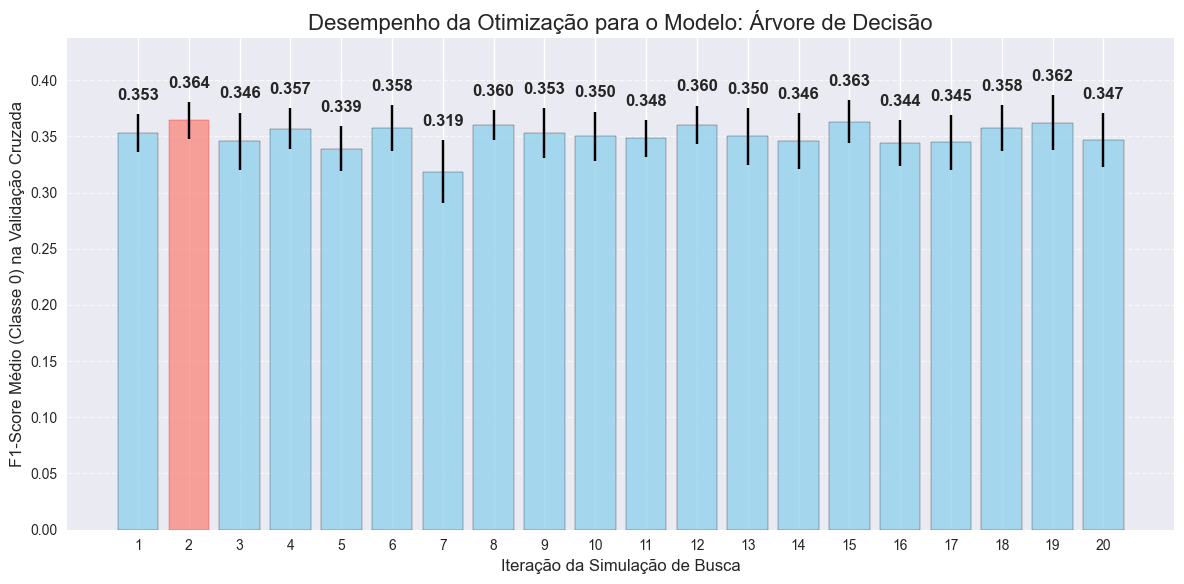

Melhores Parâmetros Gerais para 'Árvore de Decisão':
{'classifier__class_weight': None, 'classifier__criterion': 'entropy', 'classifier__max_depth': 19, 'classifier__min_samples_leaf': 7, 'classifier__min_samples_split': 7}
----------------------------------------------------------------------


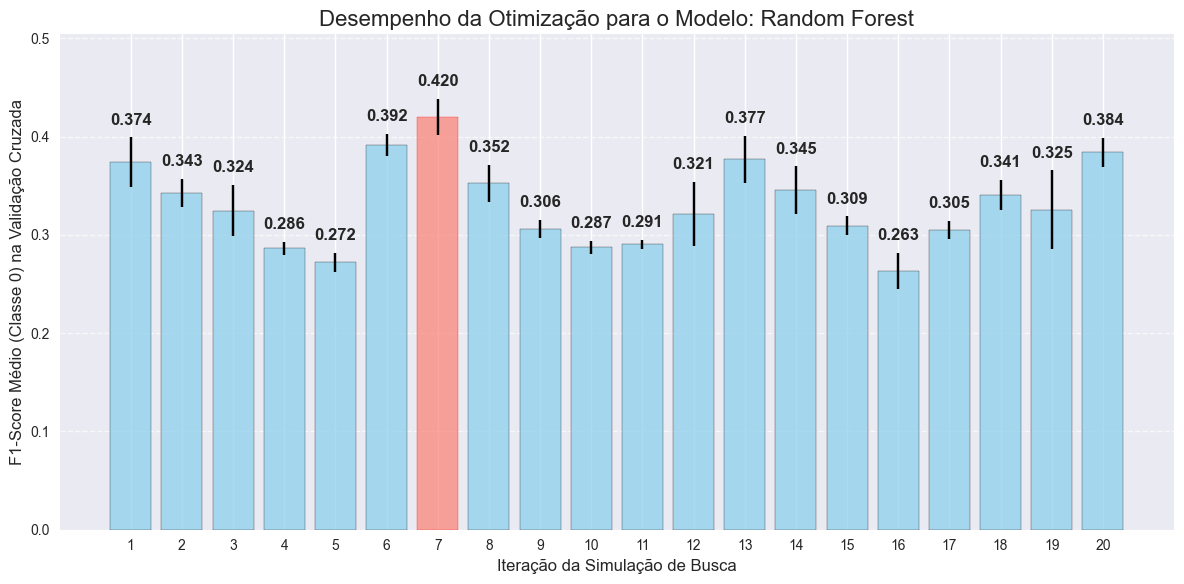

Melhores Parâmetros Gerais para 'Random Forest':
{'classifier__bootstrap': True, 'classifier__class_weight': None, 'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 248}
----------------------------------------------------------------------


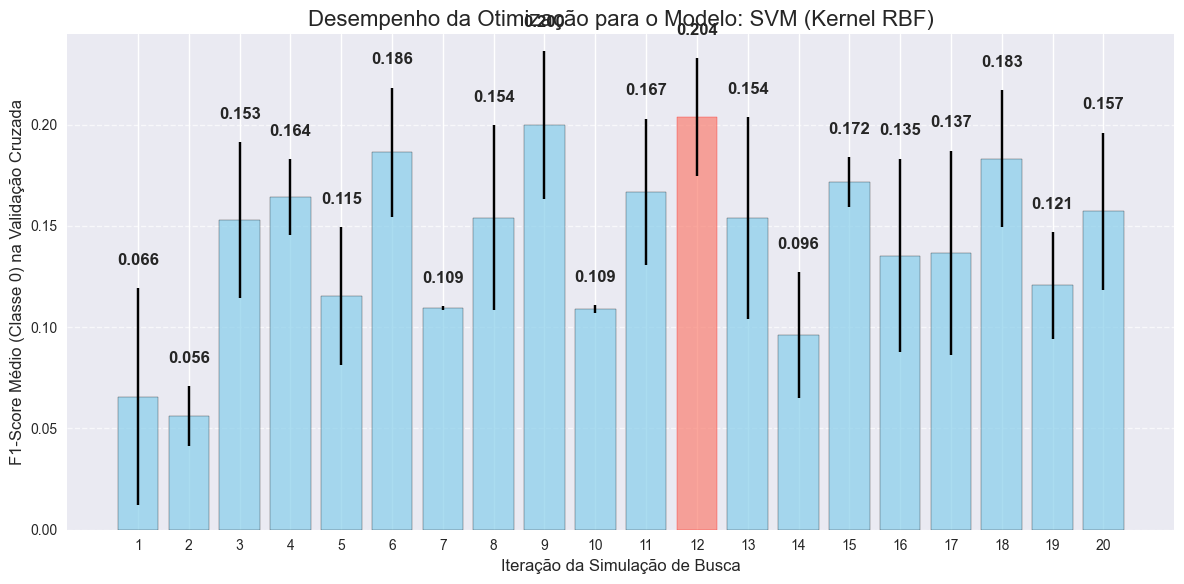

Melhores Parâmetros Gerais para 'SVM (Kernel RBF)':
{'classifier__C': np.float64(34.67266484660215), 'classifier__class_weight': None, 'classifier__gamma': np.float64(0.34577711685925183), 'classifier__kernel': 'rbf'}
----------------------------------------------------------------------


In [55]:
# Loop para gerar um gráfico para cada modelo otimizado
for name, results in all_results_fase1.items():
    mean_scores = results['mean_scores']
    std_scores = results['std_scores']
    iterations = np.arange(1, len(mean_scores) + 1)

    plt.figure(figsize=(12, 6))
    bars = plt.bar(
        iterations,
        mean_scores,
        yerr=std_scores,
        capsize=5,
        alpha=0.7,
        color='skyblue',
        edgecolor='black'
    )

    best_iter_index = np.argmax(mean_scores)
    bars[best_iter_index].set_color('salmon')
    bars[best_iter_index].set_edgecolor('red')

    plt.title(f'Desempenho da Otimização para o Modelo: {name}', fontsize=16)
    plt.xlabel('Iteração da Simulação de Busca', fontsize=12)
    plt.ylabel('F1-Score Médio (Classe 0) na Validação Cruzada', fontsize=12)
    plt.xticks(iterations)
    plt.ylim(0, max(mean_scores) * 1.2)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Adiciona o valor médio no centro da barra, acima do topo da barra de erro
    for idx, bar in enumerate(bars):
        yval = bar.get_height()
        err = std_scores[idx]
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            yval + err + 0.01,
            f'{yval:.3f}',
            ha='center',
            va='bottom',
            fontweight='bold'
        )

    plt.tight_layout()
    plt.show()

    print(f"Melhores Parâmetros Gerais para '{name}':")
    print(results['overall_best_params'])
    print("-" * 70)

In [ ]:
# Define o número de melhores resultados a serem exibidos por modelo
top_n = 5

print("--- Análise dos Hiperparâmetros Encontrados em Cada Simulação ---\n")

# Itera sobre os resultados de cada modelo
for name, results in all_results_fase1.items():
    
    # Cria um DataFrame com os parâmetros e os scores de cada simulação
    df_results = pd.DataFrame({
        'f1_score_medio': results['mean_scores'],
        'desvio_padrao': results['std_scores'],
        'parametros': results['params']
    })
    
    # Ordena o DataFrame pelo score para ver os melhores no topo
    df_results = df_results.sort_values(by='f1_score_medio', ascending=False)
    
    print(f"--- Top {top_n} Parâmetros para o Modelo: {name} ---")
    
    # Imprime os top N resultados de forma mais legível
    for index, row in df_results.head(top_n).iterrows():
        print(f"  - Score: {row['f1_score_medio']:.4f} (± {row['desvio_padrao']:.4f})")
        print(f"    Parâmetros: {row['parametros']}\n")
    
    print("-" * 70)

--- Análise dos Hiperparâmetros Encontrados em Cada Simulação ---

--- Top 5 Parâmetros para o Modelo: K-NN ---
  - Score: 0.3871 (± 0.0205)
    Parâmetros: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 5, 'classifier__weights': 'uniform'}

  - Score: 0.3871 (± 0.0205)
    Parâmetros: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 5, 'classifier__weights': 'uniform'}

  - Score: 0.3837 (± 0.0166)
    Parâmetros: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 6, 'classifier__weights': 'uniform'}

  - Score: 0.3837 (± 0.0166)
    Parâmetros: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 6, 'classifier__weights': 'uniform'}

  - Score: 0.3837 (± 0.0166)
    Parâmetros: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 6, 'classifier__weights': 'uniform'}

----------------------------------------------------------------------
--- Top 5 Parâmetros para o Modelo: Árvore de Decisão ---
  - Score: 0.3644 (± 0.0163)


Carregando modelos otimizados...
  - Modelo 'K-NN' carregado com sucesso.
  - Modelo 'Árvore de Decisão' carregado com sucesso.
  - Modelo 'Random Forest' carregado com sucesso.
  - Modelo 'SVM (Kernel RBF)' carregado com sucesso.
  - AVISO: Modelo 'GMLVQ_otimizado.pkl' não encontrado.


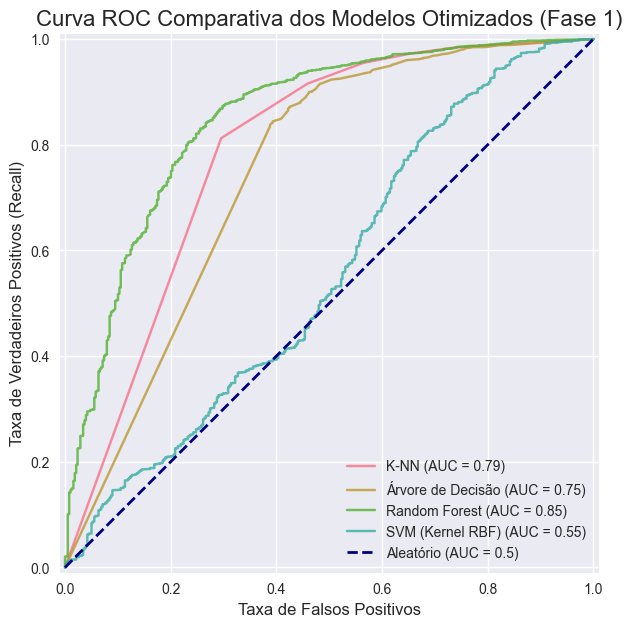

In [ ]:
# Dicionário para armazenar os melhores modelos carregados
best_models_fase1 = {}
model_names = ["K-NN", "Árvore de Decisão", "Random Forest", "SVM (Kernel RBF)", "GMLVQ"]

print("Carregando modelos otimizados...")
for name in model_names:
    try:
        best_models_fase1[name] = joblib.load(f'modelos/{name}_otimizado.pkl')
        print(f"  - Modelo '{name}' carregado com sucesso.")
    except FileNotFoundError:
        print(f"  - AVISO: Modelo '{name}_otimizado.pkl' não encontrado.")

# Cria a figura e o eixo para o plot
fig, ax = plt.subplots(figsize=(10, 7))

# Itera sobre os melhores modelos carregados para plotar cada curva
for name, model_pipeline in best_models_fase1.items():
    try:
        RocCurveDisplay.from_estimator(
            model_pipeline, 
            X_test_clean, 
            y_test, 
            name=name, 
            ax=ax, 
            alpha=0.8
        )
    except Exception as e:
        print(f"Não foi possível plotar a curva ROC para o modelo '{name}': {e}")

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatório (AUC = 0.5)')
plt.title('Curva ROC Comparativa dos Modelos Otimizados (Fase 1)', fontsize=16)
plt.xlabel('Taxa de Falsos Positivos', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos (Recall)', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### 4.2 Fase 2

Nesta etapa, foram avaliados os seguintes modelos:

- **Rede Neural MLP (Multilayer Perceptron)**
- **Comitê de Redes Neurais Artificiais (Voting MLPs)**
- **Comitê Heterogêneo (Stacking)**
- **XGBoost**
- **LightGBM**



In [21]:
# --- Dicionário de Hiperparâmetros para os modelos da FASE 2  ---
param_distributions_fase2 = {
    "XGBoost": {
        'classifier__n_estimators': randint(50, 300),
        'classifier__max_depth': randint(3, 15),
        'classifier__learning_rate': loguniform(0.01, 0.3),
        'classifier__subsample': loguniform(0.6, 1.0),
        'classifier__colsample_bytree': loguniform(0.6, 1.0),
        'classifier__gamma': loguniform(1e-4, 5.0),
        'classifier__reg_alpha': loguniform(1e-4, 1.0),  
        'classifier__reg_lambda': loguniform(1e-4, 1.0) 
    },
    "LightGBM": {
        'classifier__n_estimators': randint(50, 300),
        'classifier__max_depth': randint(3, 15),
        'classifier__learning_rate': loguniform(0.01, 0.3),
        'classifier__num_leaves': randint(20, 100),        
        'classifier__subsample': loguniform(0.6, 1.0),      
        'classifier__colsample_bytree': loguniform(0.6, 1.0),
        'classifier__reg_alpha': loguniform(1e-4, 1.0),     
        'classifier__reg_lambda': loguniform(1e-4, 1.0)     
    },
    "MLP": {
        'classifier__hidden_layer_sizes': [
            (50,), (100,),               # 1 Camada
            (50, 50), (100, 50),         # 2 Camadas
            (100, 50, 25),               # 3 Camadas (nova)
            (50, 50, 50),                # 3 Camadas (nova)
            (100, 100, 50)               # 3 Camadas (nova)
        ],
        'classifier__activation': ['tanh', 'relu'],
        'classifier__solver': ['adam', 'sgd'],
        'classifier__alpha': loguniform(1e-5, 1e-1), # Regularização
        'classifier__learning_rate': ['constant', 'adaptive']
    }
}

In [59]:
# Dicionário para armazenar os resultados detalhados de todas as iterações
all_results_fase2 = {}

# Número de iterações da nossa simulação para cada modelo
n_sim_iterations = 20

# Loop principal para otimizar cada modelo da Fase 2
for name, model in models_fase2.items():
    print(f"--> Otimizando o modelo: {name}")
    
    # Listas para armazenar resultados de cada simulação
    iteration_best_scores = []
    iteration_mean_scores = []
    iteration_std_scores = []
    iteration_params = []
    
    best_overall_score = -1
    
    # Loop para executar múltiplas simulações da busca
    for iteration in range(n_sim_iterations):
        print(f"    Iniciando iteração {iteration+1}/{n_sim_iterations} para {name}...")

        # Ajusta o n_iter para o MLP, que é mais lento
        if name == "MLP":
            n_iter_search = 3
        else:
            n_iter_search = 10

        # Cria o pipeline com pré-processamento e reamostragem
        pipeline = create_pipeline(model, use_full=False)

        # Configura a busca aleatória de hiperparâmetros
        random_search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=param_distributions_fase2[name],
            n_iter=n_iter_search,
            cv=cv_strategy,
            scoring=scoring['f1_0'],
            n_jobs=-1,
            random_state=42 + iteration,
            verbose=0
        )

        # Executa a busca nos dados de treino
        random_search.fit(X_train_clean, y_train)
        
        # Captura dos resultados detalhados
        best_index = random_search.best_index_
        mean_cv_score = random_search.cv_results_['mean_test_score'][best_index]
        std_cv_score = random_search.cv_results_['std_test_score'][best_index]
        
        # Armazena os resultados
        iteration_best_scores.append(random_search.best_score_)
        iteration_mean_scores.append(mean_cv_score)
        iteration_std_scores.append(std_cv_score)
        iteration_params.append(random_search.best_params_)
        
        print(f"        -> Iteração {iteration+1}: Best F1-Score (classe 0): {random_search.best_score_:.4f}")
        print(f"        -> Parâmetros: {random_search.best_params_}")
        print(f"        -> Média CV: {mean_cv_score:.4f} | Desvio CV: {std_cv_score:.4f}")

        # Salva o melhor modelo encontrado até agora
        if random_search.best_score_ > best_overall_score:
            best_overall_score = random_search.best_score_
            joblib.dump(random_search.best_estimator_, f'modelos/{name}_otimizado.pkl')
            print(f"        -> Novo melhor modelo salvo para '{name}' (F1-Score: {best_overall_score:.4f})")
    
    # Armazena todos os resultados para este modelo
    all_results_fase2[name] = {
        'best_scores': iteration_best_scores,
        'mean_scores': iteration_mean_scores,
        'std_scores': iteration_std_scores,
        'params': iteration_params,
        'overall_best_score': best_overall_score,
        'overall_best_params': iteration_params[np.argmax(iteration_best_scores)]
    }
    
    # Resumo dos resultados para este modelo
    print(f"\n    Otimização de '{name}' concluída.")
    print(f"    Melhor F1-Score (classe 0) encontrado: {best_overall_score:.4f}")
    print(f"    Melhores Parâmetros: {all_results_fase2[name]['overall_best_params']}")
    print("-" * 70)

--> Otimizando o modelo: MLP
    Iniciando iteração 1/20 para MLP...
        -> Iteração 1: Best F1-Score (classe 0): 0.2042
        -> Parâmetros: {'classifier__activation': 'tanh', 'classifier__alpha': np.float64(0.0024400607090817534), 'classifier__hidden_layer_sizes': (100,), 'classifier__learning_rate': 'constant', 'classifier__solver': 'adam'}
        -> Média CV: 0.2042 | Desvio CV: 0.0425
        -> Novo melhor modelo salvo para 'MLP' (F1-Score: 0.2042)
    Iniciando iteração 2/20 para MLP...
        -> Iteração 2: Best F1-Score (classe 0): 0.2392
        -> Parâmetros: {'classifier__activation': 'tanh', 'classifier__alpha': np.float64(4.881240952336934e-05), 'classifier__hidden_layer_sizes': (100, 50), 'classifier__learning_rate': 'adaptive', 'classifier__solver': 'adam'}
        -> Média CV: 0.2392 | Desvio CV: 0.0385
        -> Novo melhor modelo salvo para 'MLP' (F1-Score: 0.2392)
    Iniciando iteração 3/20 para MLP...
        -> Iteração 3: Best F1-Score (classe 0): 0.140

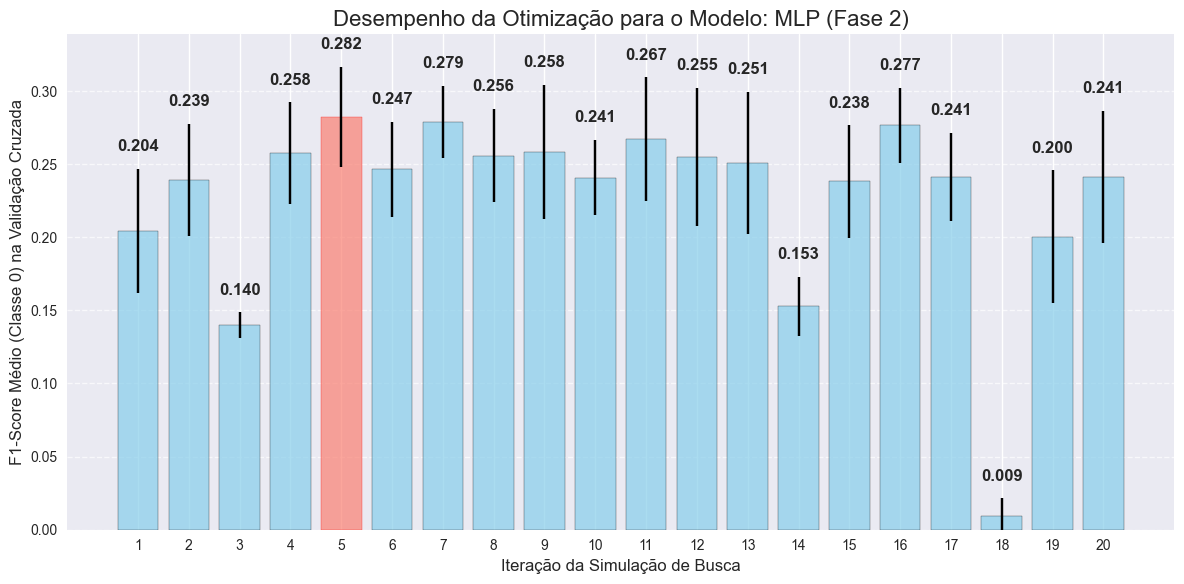

Melhores Parâmetros Gerais para 'MLP':
{'classifier__activation': 'tanh', 'classifier__alpha': np.float64(6.602922380347146e-05), 'classifier__hidden_layer_sizes': (100, 50, 25), 'classifier__learning_rate': 'adaptive', 'classifier__solver': 'adam'}
----------------------------------------------------------------------


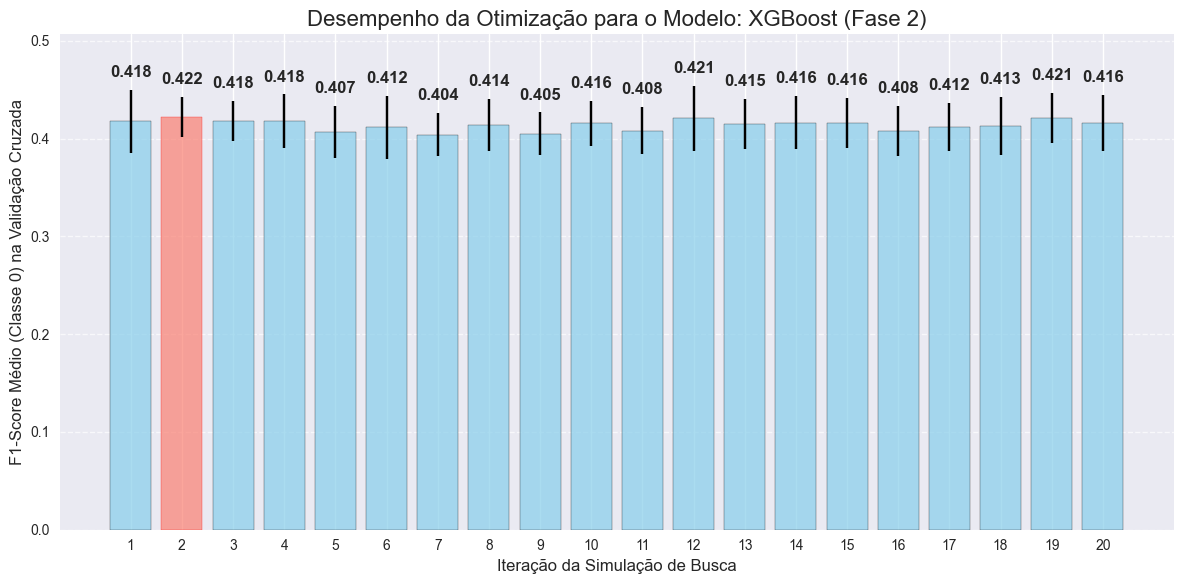

Melhores Parâmetros Gerais para 'XGBoost':
{'classifier__colsample_bytree': np.float64(0.7022164989230112), 'classifier__gamma': np.float64(0.06951946008790896), 'classifier__learning_rate': np.float64(0.14004622651042972), 'classifier__max_depth': 9, 'classifier__n_estimators': 194, 'classifier__reg_alpha': np.float64(0.018234869311881036), 'classifier__reg_lambda': np.float64(0.00015954403860183396), 'classifier__subsample': np.float64(0.7498890160380371)}
----------------------------------------------------------------------


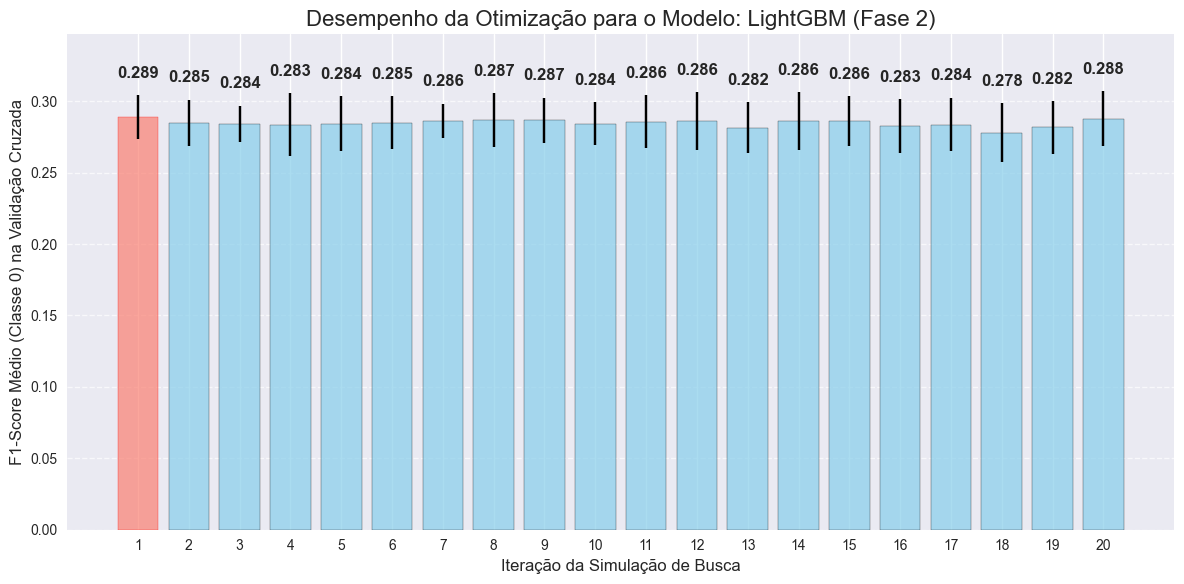

Melhores Parâmetros Gerais para 'LightGBM':
{'classifier__colsample_bytree': np.float64(0.8193665800680516), 'classifier__learning_rate': np.float64(0.170110026976697), 'classifier__max_depth': 5, 'classifier__n_estimators': 255, 'classifier__num_leaves': 55, 'classifier__reg_alpha': np.float64(0.000535728006960183), 'classifier__reg_lambda': np.float64(0.10506199451597038), 'classifier__subsample': np.float64(0.745541030315064)}
----------------------------------------------------------------------


In [62]:
# Loop para gerar um gráfico para cada modelo otimizado
for name, results in all_results_fase2.items():
    mean_scores = results['mean_scores']
    std_scores = results['std_scores']
    iterations = np.arange(1, len(mean_scores) + 1)

    plt.figure(figsize=(12, 6))
    bars = plt.bar(
        iterations,
        mean_scores,
        yerr=std_scores,
        capsize=5,
        alpha=0.7,
        color='skyblue',
        edgecolor='black'
    )

    best_iter_index = np.argmax(mean_scores)
    bars[best_iter_index].set_color('salmon')
    bars[best_iter_index].set_edgecolor('red')

    plt.title(f'Desempenho da Otimização para o Modelo: {name} (Fase 2)', fontsize=16)
    plt.xlabel('Iteração da Simulação de Busca', fontsize=12)
    plt.ylabel('F1-Score Médio (Classe 0) na Validação Cruzada', fontsize=12)
    plt.xticks(iterations)
    plt.ylim(0, max(mean_scores) * 1.2)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Adiciona o valor médio acima do topo da barra de erro
    for idx, bar in enumerate(bars):
        yval = bar.get_height()
        err = std_scores[idx]
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            yval + err + 0.01,
            f'{yval:.3f}',
            ha='center',
            va='bottom',
            fontweight='bold'
        )

    plt.tight_layout()
    plt.show()

    print(f"Melhores Parâmetros Gerais para '{name}':")
    print(results['overall_best_params'])
    print("-" * 70)

In [22]:
# Dicionário para armazenar os melhores modelos carregados da Fase 2
best_models_fase2 = {}
model_names_fase2 = ["MLP", "XGBoost", "LightGBM"]

print("Carregando modelos otimizados da Fase 2...")
for name in model_names_fase2:
    # Carrega o arquivo .pkl salvo na etapa de otimização
    try:
        best_models_fase2[name] = joblib.load(f'modelos/{name}_otimizado.pkl')
        print(f"  - Modelo '{name}' carregado com sucesso.")
    except FileNotFoundError:
        print(f"  - AVISO: Modelo '{name}_otimizado.pkl' não encontrado.")

Carregando modelos otimizados da Fase 2...
  - Modelo 'MLP' carregado com sucesso.
  - Modelo 'XGBoost' carregado com sucesso.
  - Modelo 'LightGBM' carregado com sucesso.


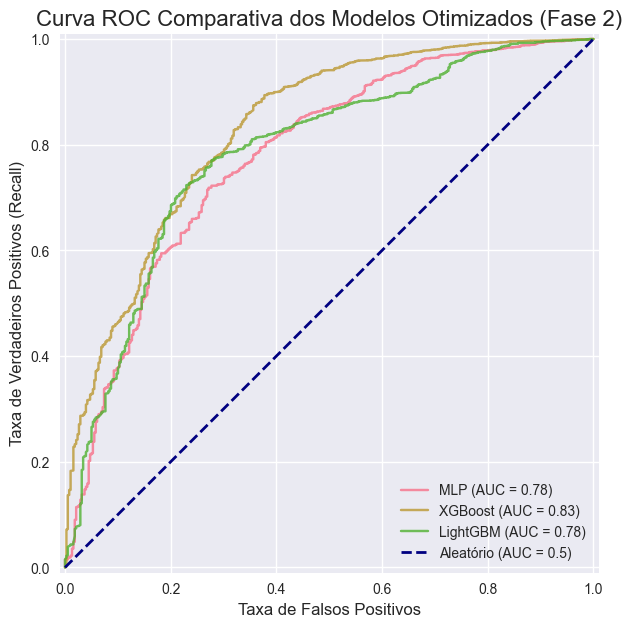

In [23]:
# Cria a figura e o eixo para o plot
fig, ax = plt.subplots(figsize=(10, 7))

# Itera sobre os melhores modelos carregados para plotar cada curva
for name, model_pipeline in best_models_fase2.items():
    try:
        RocCurveDisplay.from_estimator(
            model_pipeline, 
            X_test_clean, 
            y_test, 
            name=name, 
            ax=ax, 
            alpha=0.8
        )
    except Exception as e:
        print(f"Não foi possível plotar a curva ROC para o modelo '{name}': {e}")


# Adiciona a linha de referência (classificador aleatório)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatório (AUC = 0.5)')

# Customiza o gráfico
plt.title('Curva ROC Comparativa dos Modelos Otimizados (Fase 2)', fontsize=16)
plt.xlabel('Taxa de Falsos Positivos', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos (Recall)', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

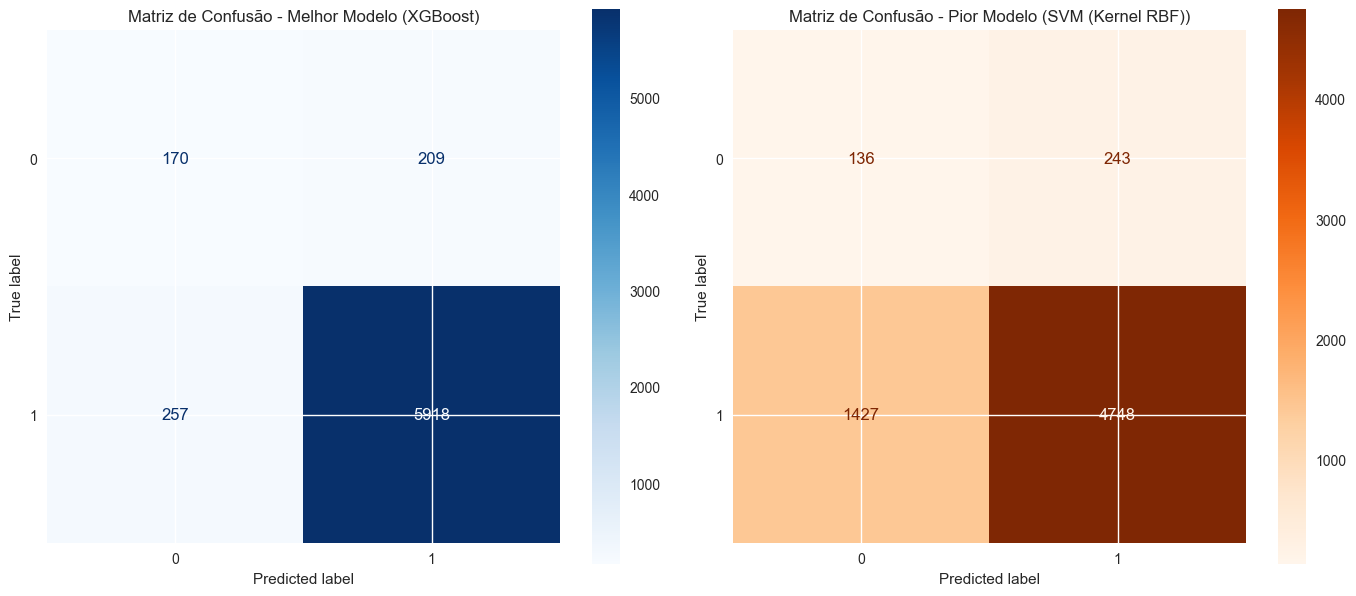

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define explicitamente os nomes dos modelos
best_model_name = "XGBoost"
worst_model_name = "SVM (Kernel RBF)"

# Carrega os pipelines otimizados
best_model = joblib.load(f'modelos/{best_model_name}_otimizado.pkl')
worst_model = joblib.load(f'modelos/{worst_model_name}_otimizado.pkl')

# Faz as previsões
y_pred_best = best_model.predict(X_test_clean)
y_pred_worst = worst_model.predict(X_test_clean)

# Plota as matrizes de confusão
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best, ax=axes[0], cmap='Blues')
axes[0].set_title(f'Matriz de Confusão - Melhor Modelo ({best_model_name})')

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_worst, ax=axes[1], cmap='Oranges')
axes[1].set_title(f'Matriz de Confusão - Pior Modelo ({worst_model_name})')

plt.tight_layout()
plt.show()


### Otimização Stacking

In [ ]:
# Carregando os modelos otimizados
print("Carregando modelos otimizados para usar no Stacking...")

# Carrega os modelos otimizados
xgb_otimizado = joblib.load('modelos/xgboost_otimizado.pkl')
print("  - XGBoost otimizado carregado com sucesso.")

rf_otimizado = joblib.load('modelos/Random Forest_otimizado.pkl')
print("  - Random Forest otimizado carregado com sucesso.")

mlp_otimizado = joblib.load('modelos/MLP_otimizado.pkl')
print("  - MLP otimizado carregado com sucesso.")

# Estimadores base otimizados para o Stacking
estimators_otimizados = [
    ('xgb', xgb_otimizado),
    ('rf', rf_otimizado),
    ('mlp', mlp_otimizado)
]

print("Modelos carregados e prontos para uso no Stacking.")

Carregando modelos otimizados para usar no Stacking...
  - XGBoost otimizado carregado com sucesso.
  - Random Forest otimizado carregado com sucesso.
  - MLP otimizado carregado com sucesso.
Modelos carregados e prontos para uso no Stacking.


In [ ]:
# Parâmetros para otimização do Stacking
param_distributions_stacking = {
    'classifier__final_estimator': [estimator for name, estimator in estimators_otimizados],
    'classifier__cv': [3, 5],
    'classifier__passthrough': [True, False]
}

# Dicionário para armazenar resultados do Stacking
all_results_stacking = {}

print("Iniciando otimização do Comitê Heterogêneo (Stacking)...")

# Lista para armazenar resultados de cada simulação
iteration_best_scores = []
iteration_mean_scores = []
iteration_std_scores = []
iteration_params = []

best_overall_score = -1
n_sim_iterations = 1

# Loop para múltiplas simulações
for iteration in range(n_sim_iterations):
    print(f"    Iteração {iteration+1}/{n_sim_iterations} para Stacking...")
    
    # Cria o modelo Stacking
    stacking_model = StackingClassifier(
        estimators=estimators_otimizados,
        final_estimator=RandomForestClassifier(random_state=42),
        cv=cv_strategy,
        stack_method='predict',
        n_jobs=-1
    )
    
    # Cria o pipeline
    pipeline = create_pipeline(stacking_model, use_full=False)
    
    # Busca aleatória
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions_stacking,
        n_iter=5,
        cv=cv_strategy,
        scoring=scoring['f1_0'],
        n_jobs=-1,
        random_state=42 + iteration,
        verbose=0
    )
    
    # Executa a busca
    random_search.fit(X_train_clean, y_train)
    
    # Captura resultados
    best_index = random_search.best_index_
    mean_cv_score = random_search.cv_results_['mean_test_score'][best_index]
    std_cv_score = random_search.cv_results_['std_test_score'][best_index]
    
    iteration_best_scores.append(random_search.best_score_)
    iteration_mean_scores.append(mean_cv_score)
    iteration_std_scores.append(std_cv_score)
    iteration_params.append(random_search.best_params_)
    
    print(f"        -> F1-Score: {random_search.best_score_:.4f}")
    print(f"        -> Parâmetros: {random_search.best_params_}")
    
    # Salva o melhor modelo
    if random_search.best_score_ > best_overall_score:
        best_overall_score = random_search.best_score_
        joblib.dump(random_search.best_estimator_, 'modelos/Stacking_otimizado.pkl')
        print(f"        -> Novo melhor Stacking salvo (F1-Score: {best_overall_score:.4f})")

# Armazena resultados
all_results_stacking['Stacking'] = {
    'best_scores': iteration_best_scores,
    'mean_scores': iteration_mean_scores,
    'std_scores': iteration_std_scores,
    'params': iteration_params,
    'overall_best_score': best_overall_score,
    'overall_best_params': iteration_params[np.argmax(iteration_best_scores)]
}

print(f"\nOtimização do Stacking concluída.")
print(f"Melhor F1-Score: {best_overall_score:.4f}")
print(f"Melhores Parâmetros: {all_results_stacking['Stacking']['overall_best_params']}")